# Workflow Notebook
This notebook is intended to present models which are loaded from other files as well as the results they allow us to reach.

## Global variables and imports

In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import (Input, Conv1D, Dense, Dropout,
                          GlobalMaxPooling1D, GlobalMaxPooling2D)
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
NB_CATEGORIES = 52
BATCHSIZE = 32

dataFolder = './../posos-data-challenge/challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(
    dataFolder, 'challenge_output_data_training_file_predict_the_expected_answer.csv')

In [3]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.maxNumberWords = (1e5)
        self.trainable = kwargs.get('trainable', False)

        self.tokenizer = text.Tokenizer(num_words=self.maxNumberWords)

    def preprocess(self, x):
        '''Turns sentences into padded word sequences.'''

        self.tokenizer.fit_on_texts(x)
        sequences = self.tokenizer.texts_to_sequences(x)
        sequences = sequence.pad_sequences(sequences, self.paddingLength)

        return sequences

    def preprocessLabels(self, labels):
        return to_categorical(labels, num_classes=self.nbCategories)

    def train(self, x, y, epochs=5, batch_size=BATCHSIZE, validation_data=None,
              callback=False):
        if callback == True:
            filepath= 'models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data,
                           callbacks=callbacks_list)
        else:
            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

## Customize generic workflow

### Perform spelling corrections

In [4]:
correctionsPath = os.path.join(dataFolder, 'corrections.csv')

In [5]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def spellingCorrection(self, x, correct_dict={}, verbose=False):
        corrected_x = []
        for w in x.split():
            if w in correct_dict.keys():
                w_corrected = corrected_dict[w]
                if verbose == True:
                    print('Correction of ' + w + ' in ' + w_corrected)
                w = w_corrected
            corrected_x.append(w)
        return ' '.join(corrected_x)

### Differenciate medics from other words
We here use a list of medication names to distinguish better between common words and specialized ones.

In [6]:
MEDICAMENTS = []
medicsPath = os.path.join(dataFolder, 'medicaments_france.xls')
medic_db = pd.read_excel(medicsPath)

for m in medic_db['Dénomination spécialité']:
    med = []
    for w in m.split():
        if w.lower()!=w:
            med.append(w)
    med = ' '.join(med)
    if len(med)!=0:
        med = med.lower()
        if med not in MEDICAMENTS:
            MEDICAMENTS.append(med.lower())

for m in medic_db['Libellé ATC']:
    med = m.split()[0].lower()
    if med not in MEDICAMENTS:
        MEDICAMENTS.append(med)

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8275
Sample of medicament names:  ['ubistesin adrenalinee', 'forene,', 'sevorane,', 'chirocaïne', 'duodopa', 'synagis', 'kaletra', 'humira', 'norvir', 'viekirax']


In [7]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.medicaments = kwargs['medicaments']

### Designing the Model itself

In [8]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildModel(self, embedding, drop_rate=0.5, nb_filters=32, filter_size=3):
        self.embedding = embedding

        my_input = keras.Input(shape=(self.paddingLength,), name= 'input')

        embedding = (Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding'))(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop1')(embedding)

        conv1 = Conv1D(nb_filters, filter_size,
                      activation='relu', name='conv1')(embedding_dropped)
        pooled_conv1 = GlobalMaxPooling1D(name='pool1')(conv1)
        pooled_conv_dropped1 = Dropout(drop_rate, name='drop2')(pooled_conv1)
        
        dense1 = Dense(100, activation='relu', name='dense1')(pooled_conv_dropped1)
        dropout2 = Dropout(0.1, name='drop3')(dense1)

        prob = Dense(self.nbCategories,
                     activation='softmax', name='dense2')(dropout2)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

## Training the Model

In [22]:
# Model variables
TRAINABLE = False
PADDING = 150
EPOCHS = 10
PRE_TRAINED_DIM = 300 # Size of the pretrained embedding used here

# Model parameters among (drop_rate=0.5, nb_filters=32, filter_size=3)
DROP_RATE = 0.5
NB_FILTERS = 100
FILTER_SIZE = 3

In [23]:
# Model instance creation
model = CustomModel(nbCategories=NB_CATEGORIES, trainable=TRAINABLE, medicaments=MEDICAMENTS)

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

In [24]:
# Correct spelling mistakes
corrected_dict = {}
for key, val in csv.reader(open(correctionsPath)):
    corrected_dict[key] = val
for i, s in enumerate(x):
    x[i] = model.spellingCorrection(s, corrected_dict, verbose = False)

In [25]:
# Print some info about our vocabulary
model.preprocess(x)
x_vocab  = list(model.tokenizer.word_index.keys())
print('Vocabulary size: ', len(x_vocab))

Vocabulary size:  10141


In [13]:
# Loading and using pretrained embedding

# Using fasttext
path2embedding = './../wiki.fr.vec'
pre_trained_wv = gensim.models.KeyedVectors.load_word2vec_format(path2embedding,
                                                                 binary=False)

# We use an embedding size of len(x_vocab) + 1 because the 0 is used for the padding
embeddings = np.zeros((len(x_vocab) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []

for word, idx in model.tokenizer.word_index.items():
    if word not in pre_trained_wv.vocab:
        vec = np.zeros(PRE_TRAINED_DIM)
        not_in_pretrained.append(word)
    else:
        vec = pre_trained_wv[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  2760


In [26]:
# Build our model
model.buildModel(embeddings, drop_rate=DROP_RATE,
                 nb_filters=NB_FILTERS, filter_size=FILTER_SIZE)
model.model.summary()

print('Total number of model parameters:', model.model.count_params())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150)               0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          3042600   
_________________________________________________________________
drop1 (Dropout)              (None, 150, 300)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 148, 100)          90100     
_________________________________________________________________
pool1 (GlobalMaxPooling1D)   (None, 100)               0         
_________________________________________________________________
drop2 (Dropout)              (None, 100)               0         
_________________________________________________________________
dense1 (Dense)               (None, 100)               10100     
__________

In [27]:
# Preprocess input data and labels before training
y = model.preprocessLabels(y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

xTrain = model.preprocess(xTrain)
xTest = model.preprocess(xTest)

In [ ]:
# Training
model.train(xTrain, yTrain, epochs=EPOCHS)

Epoch 1/10
6422/6422 [==============================] - 7s 1ms/step - loss: 3.3439 - acc: 0.2104
Epoch 2/10
6422/6422 [==============================] - 7s 1ms/step - loss: 3.0852 - acc: 0.2562
Epoch 3/10
3680/6422 [================>.............] - ETA: 3s - loss: 2.9443 - acc: 0.2810

## Model Evaluation

In [21]:
loss = model.evaluate(xTest, yTest)

prediction = model.predict(xTest)
predictionCategories = np.argmax(prediction, axis=1)
yTestCategories = np.argmax(yTest, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yTestCategories[i]
                      for i in range(len(yTestCategories))]) / len(yTestCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

AttributeError: 'CustomModel' object has no attribute 'model'

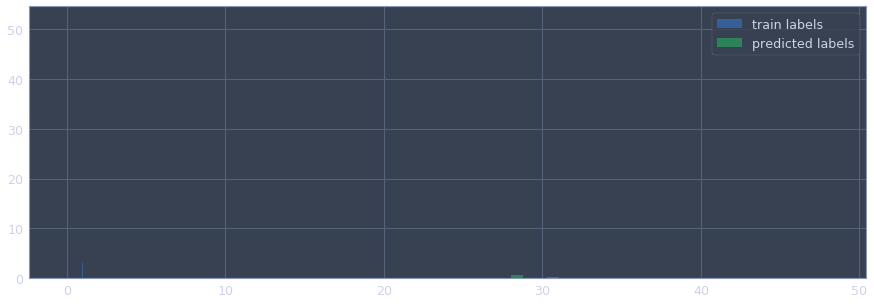

In [19]:
plt.figure(figsize=(15, 5))

plt.hist(y, bins=NB_CATEGORIES, label='train labels', density=True, alpha=0.6)
plt.hist(predictionCategories, bins=NB_CATEGORIES,
         label='predicted labels', density=True, alpha=0.6)

plt.legend()
plt.show()

In [20]:
yTestCategories

array([37, 44, 44, ..., 48, 45, 44])